In [263]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [264]:
import warnings
warnings.simplefilter('ignore')

In [265]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

##  Путь к директориям

In [266]:
DATASET_PATH = '/Users/circle/Documents/Course_project/course_project_train.csv'
TEST_DATASET_PATH = '/Users/circle/Documents/Course_project/course_project_test.csv'
PREP_DATASET_PATH = '/Users/circle/Documents/Course_project/course_project_train_prep.csv'

In [267]:
# output
TRAIN_FULL_PATH = '/Users/circle/Documents/Course_project/training_project_train_full.csv'
TRAIN_PART_PATH = '/Users/circle/Documents/Course_project/training_project_train_part_b.csv'
TEST_PART_PATH = '/Users/circle/Documents/Course_project/training_project_test_part.csv'
TEST_DATASET_PRED = '/Users/circle/Documents/Course_project/PleshkovAA_predictions.csv'

SCALER_FILE_PATH = '/Users/circle/Documents/Course_project/scaler.pkl'

In [268]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(DATASET_PATH)

In [269]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [270]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [271]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [272]:
df_test.shape

(2500, 16)

**Обзор номинативных признаков**

In [273]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков

In [274]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [275]:
df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median(axis=0),axis=0)

In [276]:
df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median(axis=0),axis=0)

In [277]:
# Так как более 50% пропусков по признаку Months since last delinquent - удаляю
df.drop(['Months since last delinquent'], axis=1, inplace=True)

In [278]:
df['Years in current job'].mode()[0]

'10+ years'

In [279]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [280]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]

### Построение новых признаков

In [281]:
df['ID'] = df.index.tolist()

**Dummies**

In [282]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [283]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7500 non-null   object 
 1   Annual Income                   7500 non-null   float64
 2   Years in current job            7500 non-null   object 
 3   Tax Liens                       7500 non-null   float64
 4   Number of Open Accounts         7500 non-null   float64
 5   Years of Credit History         7500 non-null   float64
 6   Maximum Open Credit             7500 non-null   float64
 7   Number of Credit Problems       7500 non-null   float64
 8   Bankruptcies                    7500 non-null   float64
 9   Purpose                         7500 non-null   object 
 10  Term                            7500 non-null   int64  
 11  Current Loan Amount             7500 non-null   float64
 12  Current Credit Balance          75

In [285]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

**Выделение целевой переменной и групп признаков**

In [286]:
df_base.drop(['Months since last delinquent'], axis=1, inplace=True) 

In [287]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()


### Анализ целевой переменной

**Обзор распределения**

In [288]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

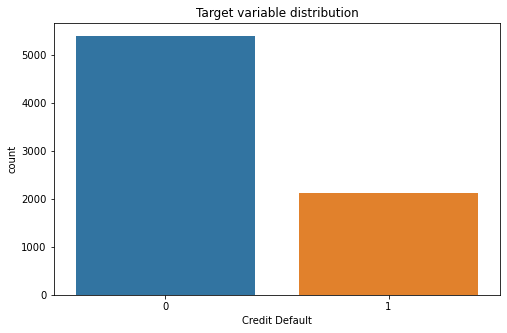

In [289]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

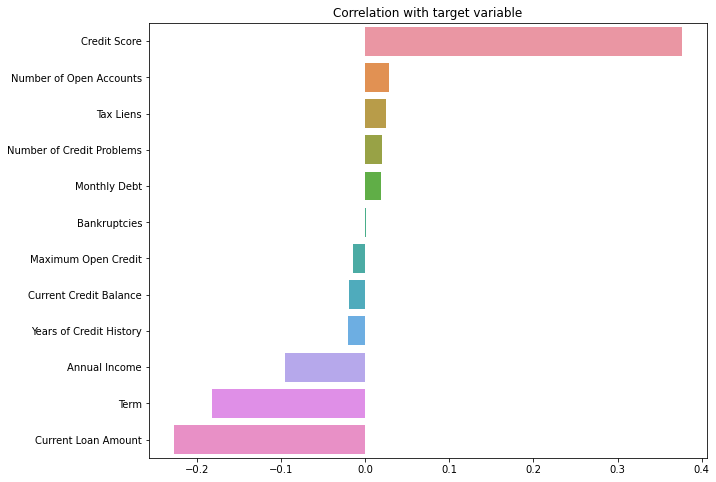

In [290]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Отбор признаков

In [291]:
CAT_FEATURE_NAMES = df_base.select_dtypes(include='object').columns.tolist()

In [292]:
NUM_FEATURE_NAMES = df_base.columns.drop(CAT_FEATURE_NAMES+[TARGET_NAME]).tolist()

In [293]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [294]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных

In [295]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [296]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [297]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
y_train.mean(), y_test.mean()

(0.2817142857142857, 0.2817777777777778)

### Балансировка целевой переменной

In [298]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)

In [299]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [300]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

In [301]:
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [302]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [303]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [304]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [305]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.88      0.74      3771
           1       0.70      0.37      0.48      2958

    accuracy                           0.65      6729
   macro avg       0.67      0.62      0.61      6729
weighted avg       0.67      0.65      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1616
           1       0.50      0.34      0.41       634

    accuracy                           0.72      2250
   macro avg       0.64      0.61      0.61      2250
weighted avg       0.70      0.72      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1400  216
1                416  218


**k ближайших соседей**

In [306]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3771
           1       0.76      0.62      0.69      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.73      0.74      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1616
           1       0.29      0.30      0.29       634

    accuracy                           0.59      2250
   macro avg       0.50      0.50      0.50      2250
weighted avg       0.60      0.59      0.60      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1142  474
1                443  191


**Бустинговые алгоритмы**

In [307]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3771
           1       0.95      0.89      0.92      2958

    accuracy                           0.93      6729
   macro avg       0.94      0.93      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1616
           1       0.53      0.44      0.48       634

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1363  253
1                353  281


*CatBoost*

In [308]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      3771
           1       0.94      0.86      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.92      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.55      0.45      0.49       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                351  283


In [309]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3771
           1       0.81      0.63      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.78      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.54      0.48      0.51       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1353  263
1                331  303
CPU times: user 5.81 s, sys: 600 ms, total: 6.41 s
Wall time: 4.57 s


In [310]:
df.to_csv(TEST_DATASET_PRED, index=False, encoding='utf-8')